In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from surprise import Dataset, Reader
from surprise import SVD, KNNBasic
from surprise.prediction_algorithms.slope_one import SlopeOne
from surprise.prediction_algorithms.co_clustering import CoClustering
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.prediction_algorithms.matrix_factorization import SVDpp
from surprise import accuracy
from surprise.model_selection import cross_validate, train_test_split
from collections import defaultdict

In [2]:
data = pd.read_csv('train_triplets.txt', sep="\t", header=None)
data.columns = ['user', 'song', 'plays']

In [3]:
data = data[:10000]
data

,user,song,plays
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1
...,...,...,...
9995,8caf9a87e266a22298bd977a63489d008af241c5,SOETKSY12A8C13C666,12
9996,8caf9a87e266a22298bd977a63489d008af241c5,SOFPXJZ12A6D4F6444,1
9997,8caf9a87e266a22298bd977a63489d008af241c5,SOFRCGW12A81C21EA6,3
9998,8caf9a87e266a22298bd977a63489d008af241c5,SOFUVPZ12A6D4FCEA3,2


In [4]:
song_df =  pd.read_csv('song_data.csv')
song_df

,song_id,title,release,artist_name,year
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0
...,...,...,...,...,...
999995,SOTXAME12AB018F136,O Samba Da Vida,Pacha V.I.P.,Kiko Navarro,0
999996,SOXQYIQ12A8C137FBB,Jago Chhadeo,Naale Baba Lassi Pee Gya,Kuldeep Manak,0
999997,SOHODZI12A8C137BB3,Novemba,Dub_Connected: electronic music,Gabriel Le Mar,0
999998,SOLXGOR12A81C21EB7,Faraday,The Trance Collection Vol. 2,Elude,0


In [5]:
data_surprise = Dataset.load_from_df(data, Reader(rating_scale=(1, data['plays'].max())))
trainset, testset = train_test_split(data_surprise, test_size=.25)

In [6]:
svd = SVD()
svd_cv = np.mean(cross_validate(svd, data_surprise, measures=['RMSE'], cv=5)['test_rmse'])

sim_options = {'name': 'cosine','user_based': True}
knn = KNNBasic(k=5, sim_options=sim_options)
knn_cv = np.mean(cross_validate(knn, data_surprise, measures=['RMSE'], cv=5)['test_rmse'])

s1 = SlopeOne()
s1_cv = np.mean(cross_validate(s1, data_surprise, measures=['RMSE'], cv=5)['test_rmse'])

cc = CoClustering()
cc_cv = np.mean(cross_validate(cc, data_surprise, measures=['RMSE'], cv=5)['test_rmse'])

nmf = NMF()
nmf_cv = np.mean(cross_validate(nmf, data_surprise, measures=['RMSE'], cv=5)['test_rmse'])

svd_plus = SVDpp()
svd_plus_cv = np.mean(cross_validate(svd_plus, data_surprise, measures=['RMSE'], cv=5)['test_rmse'])

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [11]:
print(knn_cv)

4.694930771853169


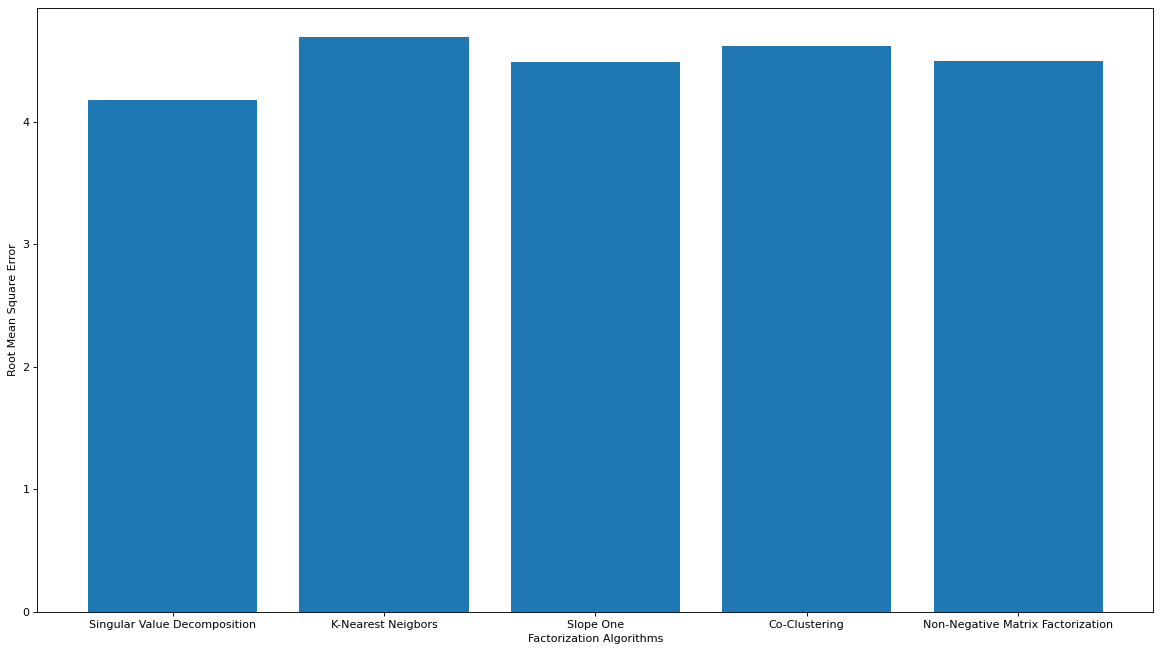

In [8]:
fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.bar([0,1,2,3,4], [svd_cv, knn_cv, s1_cv, cc_cv, nmf_cv])
plt.xticks([0,1,2,3,4], ('Singular Value Decomposition', 'K-Nearest Neigbors', 'Slope One', 'Co-Clustering', 'Non-Negative Matrix Factorization'))
plt.xlabel('Factorization Algorithms')
plt.ylabel('Root Mean Square Error')
plt.show()

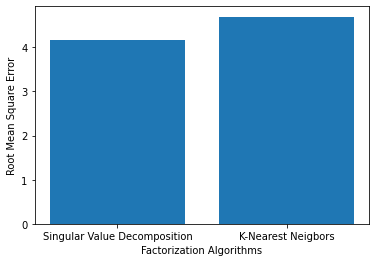

In [9]:
plt.bar([0,1], [svd_cv, knn_cv])
plt.xticks([0,1], ('Singular Value Decomposition', 'K-Nearest Neigbors'))
plt.xlabel('Factorization Algorithms')
plt.ylabel('Root Mean Square Error')
plt.show()

In [8]:
def get_top_n(user_id, predictions, n=10):
    '''Return the top-N recommendation for user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        if uid == user_id:
            top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [9]:
user_id = 'b80344d063b5ccb3212f76538f3d9e43d87dca9e'
top_n = get_top_n(user_id, predictions_svd, n=10)

recommendations = pd.DataFrame(columns=['title', 'artist', 'year'])
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    for rating in user_ratings:
        song_id = rating[0]
        song_title = song_df[song_df['song_id'] == song_id]['title'].to_string().split('    ')[1]
        artist = song_df[song_df['song_id'] == song_id]['artist_name'].to_string().split('    ')[1]
        year = song_df[song_df['song_id'] == song_id]['year'].to_string().split('    ')[1]
        recommendations = recommendations.append({'title': song_title, 'artist': artist, 'year': year}, ignore_index=True)

recommendations

,title,artist,year
0,Behind The Sea [Live In Chicago],Panic At The Disco,0
1,Paper Gangsta,Lady GaGa,2008
2,High and dry,Jorge Drexler,2006
3,I?'m A Steady Rollin? Man,Robert Johnson,0
4,Champion,Kanye West,2007
5,You Don't Have To Believe Me (Album Version),Eric Hutchinson,2008
6,The Pageant Of The Bizarre [Album Version],Zero 7,2006
7,His Majesty Rides (Album Version),Josh Rouse,0
8,Nothing from Nothing,Billy Preston,1974
9,Holes To Heaven,Jack Johnson,2003
